### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import os

import datetime
from datetime import date, timedelta

from tqdm.notebook import tqdm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
val_in_ts= pd.read_csv(os.path.join('datasets', 'timeseries', 'val_in.csv'), index_col=0, parse_dates=True)
val_in_ts.head()

,n_trips
fecha_periodo,
2021-01-01 00:00:00,6264.4850
2021-01-01 00:15:00,5716.6385
2021-01-01 00:30:00,5168.7920
2021-01-01 00:45:00,4620.9455
2021-01-01 01:00:00,4073.0990


In [3]:
val_in_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3069 entries, 2021-01-01 00:00:00 to 2021-02-01 23:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   n_trips  3069 non-null   float64
dtypes: float64(1)
memory usage: 48.0 KB


In [4]:
def read_sensor_data():
    sensor_df = pd.read_csv(os.path.join('datasets', 'sensor','raw_sensor_data.csv'), index_col=0, parse_dates=True)
    sensor_df['total'] = sensor_df['20 30 40 50 65 80 90 100 110 120 130 140 150 160 236'.split()].sum(axis=1)
    sensor_df = sensor_df[sensor_df['total']>0]

    sensor_by_roadway= sensor_df[sensor_df['total']>0].groupby(['date','roadway'])['total'].sum().to_frame()
    sensor_by_roadway=sensor_by_roadway.reset_index(level=1)
    
    r1_series = sensor_by_roadway[sensor_by_roadway['roadway']=='r1'].drop('roadway', axis=1)
    r2_series = sensor_by_roadway[sensor_by_roadway['roadway']=='r2'].drop('roadway', axis=1)

    total_sensor= sensor_df['total'].groupby('date').sum('total').to_frame()

    return r1_series, r2_series, total_sensor

r1_ts, r2_ts, total_ts = read_sensor_data()

We just keep the dates with sensor readings

In [5]:
val_in_ts = val_in_ts.loc[r1_ts.index]
val_in_ts.head()

,n_trips
fecha_periodo,
2021-01-01 10:45:00,4371.2045
2021-01-01 11:00:00,4766.6070
2021-01-01 11:15:00,5274.2645
2021-01-01 11:30:00,5781.9220
2021-01-01 11:45:00,6289.5795


# Visualización de datos

In [6]:
val_in_ts.describe()

,n_trips
count,1183.000000
mean,7176.010381
std,3532.694319
min,881.156000
25%,4262.747750
50%,7587.102250
75%,10238.887250
max,14428.677000


# Check ARIMA parameters

## Check autocorrelation

/Users/Fer/anaconda3/envs/open_sensor_data_env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


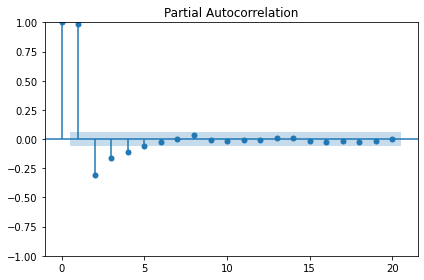

In [9]:
plot_pacf(val_in_ts, lags=20);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'city_level_pacf.png'))

In [ ]:
p=2

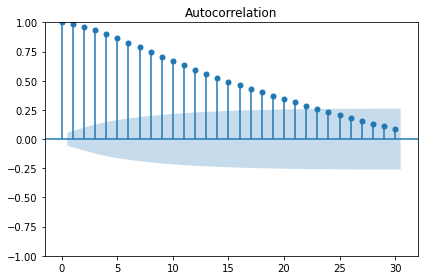

In [11]:
plot_acf(val_in_ts, lags=30);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'city_level_acf.png'))

In [28]:
q=17

### Check stationarity

In [29]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [30]:
adfuller_test(val_in_ts['n_trips'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1615
 No. Lags Chosen       = 4
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [31]:
d=0

### Forecast test

In [32]:
def mape_fn(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid, y_hat, steps_):
    y_hat= np.reshape(y_hat,(-1,steps_))
    metrics= {}
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}
    for i in range(y_valid.shape[1]):
        mae = mean_absolute_error(y_valid[:,i], y_hat[:,i])
        mse = mean_squared_error(y_valid[:,i], y_hat[:,i])
        rmse= mean_squared_error(y_valid[:,i], y_hat[:,i], squared = False)
        cvrmse =  rmse/np.mean(y_valid[:,i])*100 # it is a percentage
        mape = mape_fn(y_valid[:,i], y_hat[:,i])

        metrics_i = {}
        
        metrics_i['mae']= mae
        metrics_global['mae'].append(mae)
        
        metrics_i['mse']= mse
        metrics_global['mse'].append(mse)
        
        metrics_i['rmse']= rmse
        metrics_global['rmse'].append(rmse)
        
        metrics_i['cvrmse']= cvrmse
        metrics_global['cvrmse'].append(cvrmse)
        
        metrics_i['mape']= mape
        metrics_global['mape'].append(mape)
        
        metrics[i]= metrics_i

    metrics_global['mae']= np.mean(metrics_global['mae'])
    metrics_global['mse']= np.mean(metrics_global['mse'])
    metrics_global['rmse']= np.mean(metrics_global['rmse'])
    metrics_global['cvrmse']= np.mean(metrics_global['cvrmse'])
    metrics_global['mape']= np.mean(metrics_global['mape'])
    
    metrics['global']= metrics_global
    
    return metrics

def compute_metrics_as_dataframe_fn(y_valid, y_hat, steps_):
    y_hat= np.reshape(y_hat,(-1,steps_))
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}
    for i in range(y_valid.shape[1]):
        mae = mean_absolute_error(y_valid[:,i], y_hat[:,i])
        mse = mean_squared_error(y_valid[:,i], y_hat[:,i])
        rmse= mean_squared_error(y_valid[:,i], y_hat[:,i], squared = False)
        cvrmse =  rmse/np.mean(y_valid[:,i])*100 # it is a percentage
        mape = mape_fn(y_valid[:,i], y_hat[:,i])

        metrics.append((i, mae, mse, rmse, cvrmse, mape))
        
    
    metrics_df = pd.DataFrame.from_records(metrics, columns='T MAE MSE RMSE CVRMSE MAPE'.split())
    metrics_df = metrics_df.set_index('T')
    metrics_df.loc['global']= metrics_df.mean(axis=0)
    
    return metrics_df

In [33]:
val_in_ts['n_trips'].head()

fecha_periodo
2021-01-01 10:45:00    4371.2045
2021-01-01 11:00:00    4766.6070
2021-01-01 11:15:00    5274.2645
2021-01-01 11:30:00    5781.9220
2021-01-01 11:45:00    6289.5795
Name: n_trips, dtype: float64

In [34]:
val_in_ts['n_trips'].tail()

fecha_periodo
2021-01-31 23:00:00    1524.0430
2021-01-31 23:15:00    1632.9255
2021-01-31 23:30:00    1741.8080
2021-01-31 23:45:00    1850.6905
2021-02-01 00:00:00    1959.5730
Name: n_trips, dtype: float64

In [35]:
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides) 


# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, lr_, steps_):
    # prepare training dataset
    train_size = int(len(X) * lr_)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in tqdm(range(len(test)), leave=False, desc='t'):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=steps_)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    metrics = compute_metrics_as_dataframe_fn(rolling_window(test, steps_), predictions[:-7], steps_)
    return metrics

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in tqdm(p_values, desc='p'):
        for d in tqdm(d_values, leave=False, desc='d'):
            for q in tqdm(q_values, leave=False, desc='q'):
                order = (p,d,q)
                try:
                    metrics_ = evaluate_arima_model(dataset, order)
                    if metrics[4] < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s MAPE=%.3f' % (order,rmse))
                except:
                    continue

    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

/var/folders/kf/v1s43dsx3938g13xfjj52w9c0000gn/T/ipykernel_10024/900159185.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [36]:
lr= 0.7
n_steps_ahead= 8

arima_results= evaluate_arima_model(val_in_ts['n_trips'].values, (0,0,0), lr_= lr, steps_=n_steps_ahead)# (p,d,q))

t:   0%|          | 0/355 [00:00<?, ?it/s]

In [37]:
arima_results

,MAE,MSE,RMSE,CVRMSE,MAPE
T,,,,,
0,3219.625376,1.486593e+07,3855.636049,67.043395,134.536589
1,3221.078457,1.487652e+07,3857.008814,67.067423,134.585102
2,3222.943383,1.489155e+07,3858.957737,67.107211,134.729819
3,3225.278855,1.491131e+07,3861.517122,67.163369,135.017047
4,3226.946949,1.492375e+07,3863.127480,67.196427,135.151835
5,3228.112545,1.493107e+07,3864.074807,67.213557,135.188444
6,3228.787719,1.493324e+07,3864.355363,67.214692,135.135730
7,3228.962760,1.493025e+07,3863.967565,67.199806,135.000750
global,3225.217005,1.490795e+07,3861.080617,67.150735,134.918165


In [38]:
arima_results.to_csv(os.path.join('results', 'city_level_arima_metrics.csv'))

### Generate plot

In [ ]:
n_samples_train = int(trips_df.shape[0]*0.7)
n_samples_train

In [ ]:
X= trips_df.iloc[:n_samples_train]


In [ ]:
ine_true_train = []
ine_hat_train = []
look_back=7
for i in range(look_back, n_samples_train):
    X= trips_df.iloc[i-look_back:i]
    X_differenced = X.dropna()
    
    y =trips_df.iloc[i+1]
    y_true_ine = y[1]#[v[1] for v in y.values]
    
    y_hat = model_fitted.forecast(y=X_differenced.values[-7:])[0]
    df_forecast = pd.DataFrame(y_hat, index=trips_df.iloc[i:i+1].index, columns=trips_df.columns + '_forecast')

    #columns = trips_df.columns
    #for col in columns:  
    #    df_forecast[str(col)+'_forecast'] = X[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()

    y_hat_ine = list(df_forecast['open_data_trips_forecast'].values)
    #print(y_true_ine, y_hat_ine)
    ine_true_train = ine_true_train + y_true_ine
    ine_hat_train = ine_hat_train + y_hat_ine

In [ ]:
ine_true_test = []
ine_hat_test = []
look_back=7
for i in range(n_samples_train, trips_df.shape[0]-look_back):
    X= trips_df.iloc[i-look_back:i]
    X_differenced = X.dropna()
    
    y =trips_df.iloc[i+1]
    y_true_ine = y[1]#[v[1] for v in y.values]
    
    y_hat = model_fitted.forecast(y=X_differenced.values[-7:], steps=1)
    df_forecast = pd.DataFrame(y_hat, index=trips_df.iloc[i:i+1].index, columns=trips_df.columns + '_forecast')
    
    #columns = trips_df.columns
    #for col in columns:  
    #    df_forecast[str(col)+'_forecast'] = X[col].iloc[-1] + df_forecast[str(col)+'_1d'].cumsum()

    y_hat_ine = list(df_forecast['open_data_trips_forecast'].values)
    #print(y_true_ine, y_hat_ine)
    ine_true_test = ine_true_test + y_true_ine
    ine_hat_test = ine_hat_test + y_hat_ine

In [ ]:
len(trips_df['open_data_trips'].astype(float))

In [ ]:
ine_trips = trips_df['open_data_trips'].astype(float)

In [ ]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(ine_trips)
trainPredictPlot[:] = np.nan
#trainPredictPlot[look_back+1:n_samples_train+1] = ine_hat_train
trainPredictPlot[:n_samples_train-look_back] = ine_hat_train
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(ine_trips)
testPredictPlot[:] = np.nan
#testPredictPlot[n_samples_train+1:len(ine_trips)-look_back+1] = ine_hat_test
testPredictPlot[n_samples_train-1:len(ine_trips)-(look_back)-1] = ine_hat_test
# plot baseline and predictions
plt.plot(trips_df['open_data_trips'].values)
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Raw trips', 'Training data prediction', 'Test data prediction'), loc = 'upper left')
plt.grid(True)
#plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Time", fontsize = 10)
plt.ylabel("Number of trips", fontsize = 10)
plt.tight_layout()
plt.savefig('var_ine_twt_pred.png')
plt.show()

In [ ]:
print("That's all folks!")